In [ ]:
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p /content/data/amazon-book

BASE="https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book"

!wget $BASE/train.txt      -P /content/data/amazon-book
!wget $BASE/test.txt       -P /content/data/amazon-book
!wget $BASE/user_list.txt  -P /content/data/amazon-book
!wget $BASE/item_list.txt  -P /content/data/amazon-book


--2025-11-25 16:16:53--  https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14125691 (13M) [text/plain]
Saving to: ‘/content/data/amazon-book/train.txt’

train.txt           100%[===================>]  13.47M  --.-KB/s    in 0.09s   

2025-11-25 16:16:54 (157 MB/s) - ‘/content/data/amazon-book/train.txt’ saved [14125691/14125691]

--2025-11-25 16:16:54--  https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

In [ ]:
def load_amazon_book_train(data_dir):
    """
    data_dir: katalog z plikiem train.txt
    Zwraca:
      num_users, num_items,
      user_ids (np.array),
      item_ids (np.array),
      user_pos_items: dict u -> set(itemów)
    """
    train_path = os.path.join(data_dir, "train.txt")
    user_pos_items = {}
    user_ids = []
    item_ids = []

    with open(train_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) <= 1:
                continue
            u = int(parts[0])
            items = [int(x) for x in parts[1:]]
            if not items:
                continue
            if u not in user_pos_items:
                user_pos_items[u] = set()
            for i in items:
                user_pos_items[u].add(i)
                user_ids.append(u)
                item_ids.append(i)

    user_ids = np.array(user_ids, dtype=np.int64)
    item_ids = np.array(item_ids, dtype=np.int64)

    num_users = max(user_pos_items.keys()) + 1
    num_items = item_ids.max() + 1

    return num_users, num_items, user_ids, item_ids, user_pos_items


In [ ]:
num_users, num_items, user_ids_all, item_ids_all, user_pos_items_all = \
    load_amazon_book_train("/content/data/amazon-book")

In [ ]:
def build_subset(user_pos_items_all, max_users=1000, min_interactions=5):
    """
    user_pos_items_all: dict {stare_u -> set(starych_itemów)}
    max_users: maksymalna liczba użytkowników w subsecie
    min_interactions: minimalna liczba interakcji użytkownika, żeby go brać
    Zwraca:
      num_users_sub, num_items_sub,
      user_ids_sub (np.array),
      item_ids_sub (np.array),
      user_pos_items_sub (dict z NOWYMI ID)
    """
    # filtr: tylko użytkownicy z minimum interakcji
    candidates = [u for u, items in user_pos_items_all.items()
                  if len(items) >= min_interactions]

    # przytnij do max_users
    candidates = sorted(candidates)[:max_users]

    # podzbiór interakcji
    subset_user_pos_old = {u: set(user_pos_items_all[u]) for u in candidates}

    # zbierz itemy, które faktycznie występują w tym subsecie
    item_set = set()
    for items in subset_user_pos_old.values():
        item_set.update(items)

    # mapowanie starych ID na nowe, zwarte
    user_old2new = {u_old: u_new for u_new, u_old in enumerate(sorted(subset_user_pos_old.keys()))}
    item_old2new = {i_old: i_new for i_new, i_old in enumerate(sorted(item_set))}

    # nowy dict z przemapowanymi ID
    user_pos_items_sub = {}
    for u_old, items_old in subset_user_pos_old.items():
        u_new = user_old2new[u_old]
        user_pos_items_sub[u_new] = {item_old2new[i_old] for i_old in items_old}

    # tablice do budowy adj
    user_ids_sub = []
    item_ids_sub = []
    for u_new, items_new in user_pos_items_sub.items():
        for i_new in items_new:
            user_ids_sub.append(u_new)
            item_ids_sub.append(i_new)

    user_ids_sub = np.array(user_ids_sub, dtype=np.int64)
    item_ids_sub = np.array(item_ids_sub, dtype=np.int64)

    num_users_sub = len(user_old2new)
    num_items_sub = len(item_old2new)

    return num_users_sub, num_items_sub, user_ids_sub, item_ids_sub, user_pos_items_sub

In [ ]:
num_users, num_items, user_ids_sub, item_ids_sub, user_pos_items_sub = \
   build_subset(user_pos_items_all, max_users=5000, min_interactions=5)

In [ ]:
def split_user_interactions(user_pos_items):
    train = {}
    val = {}
    test = {}

    for u, items in user_pos_items.items():
        items = list(items)
        if len(items) < 3:
            train[u] = set(items)
            continue
        # bez timestampów – po prostu losowo
        np.random.shuffle(items)
        test_item = items[0]
        val_item = items[1]
        train_items = items[2:]

        train[u] = set(train_items)
        val[u] = {val_item}
        test[u] = {test_item}

    return train, val, test

In [ ]:
train_user_pos_items, val_user_pos_items, test_user_pos_items = \
   split_user_interactions(user_pos_items_sub)
# train_user_pos_items, val_user_pos_items, test_user_pos_items = \
#     split_user_interactions(user_pos_items_all)

In [ ]:
def build_normalized_adj(num_users, num_items, user_ids, item_ids):
    """
    num_users: int
    num_items: int
    user_ids, item_ids: 1D np.array z indeksami (dopasowanymi do [0..))
    Zwraca: tf.sparse.SparseTensor reprezentujący Â = D^-1/2 A D^-1/2
    """
    num_nodes = num_users + num_items

    # Krawędzie dwudzielne: (u, v) oraz (v, u)
    # v = num_users + item
    row_idx = []
    col_idx = []

    for u, i in zip(user_ids, item_ids):
        v = num_users + i
        row_idx.append(u)
        col_idx.append(v)
        row_idx.append(v)
        col_idx.append(u)

    row_idx = np.array(row_idx, dtype=np.int64)
    col_idx = np.array(col_idx, dtype=np.int64)

    # Stopnie
    degrees = np.zeros(num_nodes, dtype=np.float32)
    for r, c in zip(row_idx, col_idx):
        degrees[r] += 1.0
        degrees[c] += 1.0

    # Wagi z normalizacją symetryczną
    values = []
    for r, c in zip(row_idx, col_idx):
        deg_r = degrees[r]
        deg_c = degrees[c]
        if deg_r > 0 and deg_c > 0:
            val = 1.0 / np.sqrt(deg_r * deg_c)
        else:
            val = 0.0
        values.append(val)

    values = np.array(values, dtype=np.float32)

    indices = np.stack([row_idx, col_idx], axis=1)

    adj = tf.sparse.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=(num_nodes, num_nodes),
    )
    # Porządkowanie indeksów
    adj = tf.sparse.reorder(adj)
    return adj


In [ ]:
class LightGCN(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim, num_layers, adj):
        super().__init__()  # bez tego Keras nic nie śledzi

        self.num_users = num_users
        self.num_items = num_items
        self.num_nodes = num_users + num_items
        self.num_layers = num_layers

        self.adj = tf.sparse.reorder(adj)

        # JEDYNY trenowalny parametr
        self.node_embeddings = self.add_weight(
            name="node_embeddings",
            shape=(self.num_nodes, embedding_dim),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True,
        )

    def propagate(self):
        # E^(0)
        E_k = self.node_embeddings          # (num_nodes, d)

        # od razu zaczynamy sumowanie po warstwach
        E_sum = E_k                         # E^(0)

        for _ in range(self.num_layers):
            # E^{k+1} = Â E^{k}
            E_k = tf.sparse.sparse_dense_matmul(self.adj, E_k)
            E_sum = E_sum + E_k             # sumujemy E^(k+1)

        # średnia po (K+1) poziomach:  (E^0 + E^1 + ... + E^K) / (K+1)
        E_final = E_sum / float(self.num_layers + 1)

        user_embs = E_final[:self.num_users]
        item_embs = E_final[self.num_users:]
        return user_embs, item_embs


In [ ]:
def bpr_loss(model, user_ids, pos_item_ids, neg_item_ids, l2_reg=1e-4):
    user_embs_final, item_embs_final = model.propagate()

    u_final = tf.nn.embedding_lookup(user_embs_final, user_ids)
    pos_final = tf.nn.embedding_lookup(item_embs_final, pos_item_ids)
    neg_final = tf.nn.embedding_lookup(item_embs_final, neg_item_ids)

    pos_scores = tf.reduce_sum(u_final * pos_final, axis=-1)
    neg_scores = tf.reduce_sum(u_final * neg_final, axis=-1)

    diff = pos_scores - neg_scores
    loss_per_sample = -tf.math.log_sigmoid(diff)
    bpr = tf.reduce_mean(loss_per_sample)

    u_ego = tf.nn.embedding_lookup(model.node_embeddings, user_ids)
    pos_ego = tf.nn.embedding_lookup(model.node_embeddings, model.num_users + pos_item_ids)
    neg_ego = tf.nn.embedding_lookup(model.node_embeddings, model.num_users + neg_item_ids)

    reg = tf.nn.l2_loss(u_ego) + tf.nn.l2_loss(pos_ego) + tf.nn.l2_loss(neg_ego)

    reg = reg / float(tf.shape(user_ids)[0])

    return bpr + l2_reg * reg

In [ ]:
def evaluate_topk(model, user_pos_train, user_pos_eval, num_items, K=20):
    user_embs, item_embs = model.propagate()
    user_embs = user_embs.numpy()
    item_embs = item_embs.numpy()

    recalls = []
    ndcgs = []

    all_items = np.arange(num_items, dtype=np.int64)

    for u, eval_items in user_pos_eval.items():
        if len(eval_items) == 0:
            continue

        # scoring wszystkich itemów
        u_vec = user_embs[u]  # (d,)
        scores = item_embs @ u_vec  # (num_items,)

        # maskowanie itemów treningowych (żeby ich nie rekomendować)
        train_items = user_pos_train.get(u, set())
        exclude = train_items  # opcjonalnie też eval/test, jeśli chcesz czysty ranking
        if exclude:
            scores[list(exclude)] = -1e9

        # top-K
        topk_idx = np.argpartition(-scores, K)[:K]
        topk_idx = topk_idx[np.argsort(-scores[topk_idx])]

        eval_items_list = list(eval_items)

        # Recall@K
        hit_count = sum(1 for i in eval_items_list if i in topk_idx)
        recall = hit_count / len(eval_items_list)
        recalls.append(recall)

        # NDCG@K
        dcg = 0.0
        idcg = 0.0
        for rank, item in enumerate(topk_idx):
            if item in eval_items_list:
                dcg += 1.0 / np.log2(rank + 2.0)
        # idealne DCG: wszystkie relewantne na początku
        for rank in range(min(len(eval_items_list), K)):
            idcg += 1.0 / np.log2(rank + 2.0)
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcgs.append(ndcg)

    mean_recall = float(np.mean(recalls)) if recalls else 0.0
    mean_ndcg = float(np.mean(ndcgs)) if ndcgs else 0.0
    return mean_recall, mean_ndcg


In [ ]:
def dict_to_arrays(user_pos_dict):
    user_ids = []
    item_ids = []
    for u, items in user_pos_dict.items():
        for i in items:
            user_ids.append(u)
            item_ids.append(i)
    return np.array(user_ids, dtype=np.int64), np.array(item_ids, dtype=np.int64)

In [ ]:
def make_bpr_sampler(user_pos_items, num_items, batch_size):
    """
    Zwraca generator batchy (user, pos_item, neg_item).
    user_pos_items: dict u -> set(itemów pozytywnych)
    num_items: liczba itemów
    """
    users = np.array(list(user_pos_items.keys()), dtype=np.int64)
    all_items = np.arange(num_items, dtype=np.int64)

    def sample_batch():
        batch_users = []
        batch_pos = []
        batch_neg = []

        for _ in range(batch_size):
            u = int(random.choice(users))
            pos_list = list(user_pos_items[u])
            i_pos = random.choice(pos_list)

            # negatywny: item nie w pozytywnych dla u
            while True:
                j = int(random.randint(0, num_items - 1))
                if j not in user_pos_items[u]:
                    i_neg = j
                    break

            batch_users.append(u)
            batch_pos.append(i_pos)
            batch_neg.append(i_neg)

        return (
            np.array(batch_users, dtype=np.int64),
            np.array(batch_pos, dtype=np.int64),
            np.array(batch_neg, dtype=np.int64),
        )

    return sample_batch


In [ ]:
@tf.function
def train_step(model, user_ids, pos_item_ids, neg_item_ids):
    with tf.GradientTape() as tape:
        loss = bpr_loss(model, user_ids, pos_item_ids, neg_item_ids)
    grads = tape.gradient(loss, model.trainable_variables)

    grads_and_vars = [
        (g, v)
        for g, v in zip(grads, model.trainable_variables)
        if g is not None
    ]

    optimizer.apply_gradients(grads_and_vars)
    return loss

In [ ]:
sampler = make_bpr_sampler(
    user_pos_items=train_user_pos_items,
    num_items=num_items,
    batch_size=2048,  # Amazon-book
)

In [ ]:
train_user_ids, train_item_ids = dict_to_arrays(train_user_pos_items)

In [ ]:
adj = build_normalized_adj(
    num_users=num_users,
    num_items=num_items,
    user_ids=train_user_ids,
    item_ids=train_item_ids,
)

In [ ]:
model = LightGCN(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=64,
    num_layers=3,
    adj=adj,
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
print("Trainable variables:")
for v in model.trainable_variables:
    print("  ", v.name, v.shape)

Trainable variables:
   node_embeddings (58783, 64)


In [ ]:
epoch_history = []
loss_history = []
val_recall_history = []
val_ndcg_history = []

In [ ]:
num_epochs = 1000
steps_per_epoch = 1000
patience = 30
validate_every = 5

best_val_recall = 0.0
epochs_no_improve = 0

epoch_history = []
loss_history = []
val_recall_history = []
val_ndcg_history = []

for epoch in range(num_epochs):
    epoch_losses = []

    for step in range(steps_per_epoch):
        u, i_pos, i_neg = sampler()
        u = tf.convert_to_tensor(u, dtype=tf.int32)
        i_pos = tf.convert_to_tensor(i_pos, dtype=tf.int32)
        i_neg = tf.convert_to_tensor(i_neg, dtype=tf.int32)

        loss_value = train_step(model, u, i_pos, i_neg)

        epoch_losses.append(loss_value.numpy())

        # logowanie co jakiś tam krok w epokach
        if (step + 1) % 100 == 0:
            print(
                f"Epoka {epoch:4d} | Krok {step+1:4d}/{steps_per_epoch} | "
                f"Loss (ostatni batch): {loss_value.numpy():.4f}"
            )

    mean_epoch_loss = float(np.mean(epoch_losses))

    # log: średni loss po epoce
    print(f"[Epoka {epoch:4d}] Średni loss: {mean_epoch_loss:.4f}")

    # walidacja co `validate_every` epok
    if epoch % validate_every == 0:
        val_recall, val_ndcg = evaluate_topk(
            model,
            user_pos_train=train_user_pos_items,
            user_pos_eval=val_user_pos_items,
            num_items=num_items,
            K=20,
        )

        print(
            f"[Epoka {epoch:4d}] "
            f"Val Recall@20: {val_recall:.4f} | Val NDCG@20: {val_ndcg:.4f}"
        )

        # zapisz do historii
        epoch_history.append(epoch)
        loss_history.append(mean_epoch_loss)
        val_recall_history.append(val_recall)
        val_ndcg_history.append(val_ndcg)

        # early stopping po Recall@20
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            epochs_no_improve = 0
            print(f"[Epoka {epoch:4d}] Nowy najlepszy Recall@20: {best_val_recall:.4f}")
        else:
            epochs_no_improve += 1
            print(
                f"[Epoka {epoch:4d}] Brak poprawy, patience = "
                f"{epochs_no_improve}/{patience}"
            )

        if epochs_no_improve >= patience:
            print(
                f"Early stopping: brak poprawy przez {patience} walidacji. "
                f"Najlepszy Recall@20 = {best_val_recall:.4f}"
            )
            break

Epoka    0 | Krok  100/1000 | Loss (ostatni batch): 0.6931
Epoka    0 | Krok  200/1000 | Loss (ostatni batch): 0.6930
Epoka    0 | Krok  300/1000 | Loss (ostatni batch): 0.6904
Epoka    0 | Krok  400/1000 | Loss (ostatni batch): 0.6635
Epoka    0 | Krok  500/1000 | Loss (ostatni batch): 0.6002
Epoka    0 | Krok  600/1000 | Loss (ostatni batch): 0.5273
Epoka    0 | Krok  700/1000 | Loss (ostatni batch): 0.4691
Epoka    0 | Krok  800/1000 | Loss (ostatni batch): 0.4300
Epoka    0 | Krok  900/1000 | Loss (ostatni batch): 0.4104
Epoka    0 | Krok 1000/1000 | Loss (ostatni batch): 0.3754
[Epoka    0] Średni loss: 0.5736
[Epoka    0] Val Recall@20: 0.0222 | Val NDCG@20: 0.0088
[Epoka    0] Nowy najlepszy Recall@20: 0.0222
Epoka    1 | Krok  100/1000 | Loss (ostatni batch): 0.3627
Epoka    1 | Krok  200/1000 | Loss (ostatni batch): 0.3596
Epoka    1 | Krok  300/1000 | Loss (ostatni batch): 0.3434
Epoka    1 | Krok  400/1000 | Loss (ostatni batch): 0.3348
Epoka    1 | Krok  500/1000 | Loss (os

Text(0.5, 1.0, 'Historia lossu')

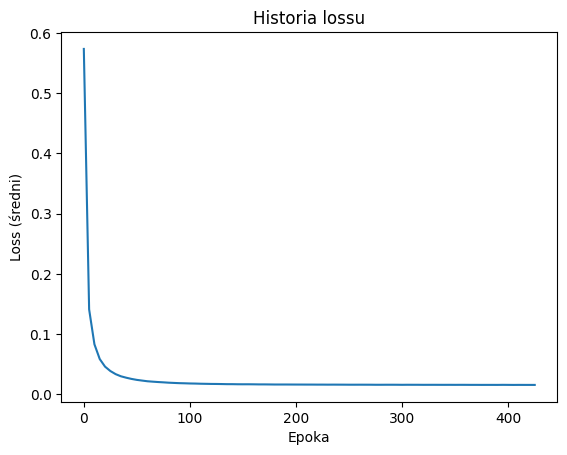

In [ ]:
# loss
plt.figure()
plt.plot(epoch_history, loss_history)
plt.xlabel("Epoka")
plt.ylabel("Loss (średni)")
plt.title("Historia lossu")

Text(0.5, 1.0, 'Recall@20 na walidacji')

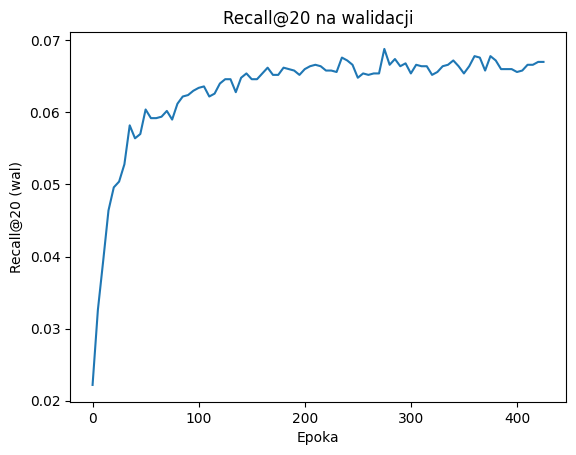

In [ ]:
# Recall@K
plt.figure()
plt.plot(epoch_history, val_recall_history)
plt.xlabel("Epoka")
plt.ylabel("Recall@20 (wal)")
plt.title("Recall@20 na walidacji")

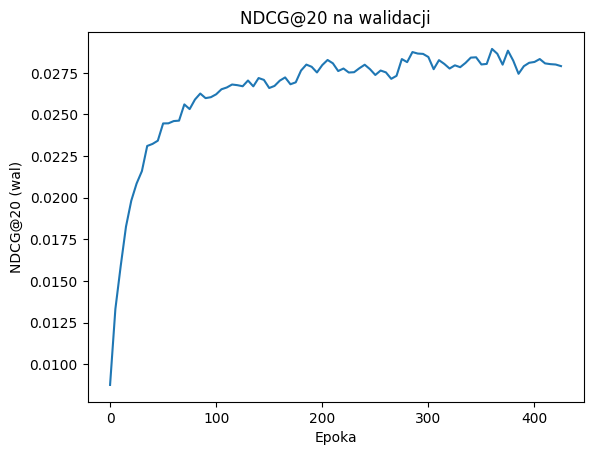

In [ ]:
# NDCG@K
plt.figure()
plt.plot(epoch_history, val_ndcg_history)
plt.xlabel("Epoka")
plt.ylabel("NDCG@20 (wal)")
plt.title("NDCG@20 na walidacji")

plt.show()